In [1]:
import keras
import sys
sys.path.append('../')
from datasets import CD_Dataset
from models import Unet
from utility import show_batches, from_categorical
import numpy as np

dataset_path = '../CD_Dataset'
trained_models_path = '../trained_models'

input_patch_size = [350,350]
input_channels = [3]
output_channels = [2]

dataset = CD_Dataset( path=dataset_path, fit=True, download=True, num_classes=output_channels[0] )



Using TensorFlow backend.


('mean_features: ', array([ 0.86503507,  0.83272585,  0.72929356]))
('std_features: ', array([ 0.01255889,  0.01785996,  0.05625756]))


xs shape (10, 350, 350, 3)
ys shape (10, 350, 350, 2)
xs type float64
ys type float64


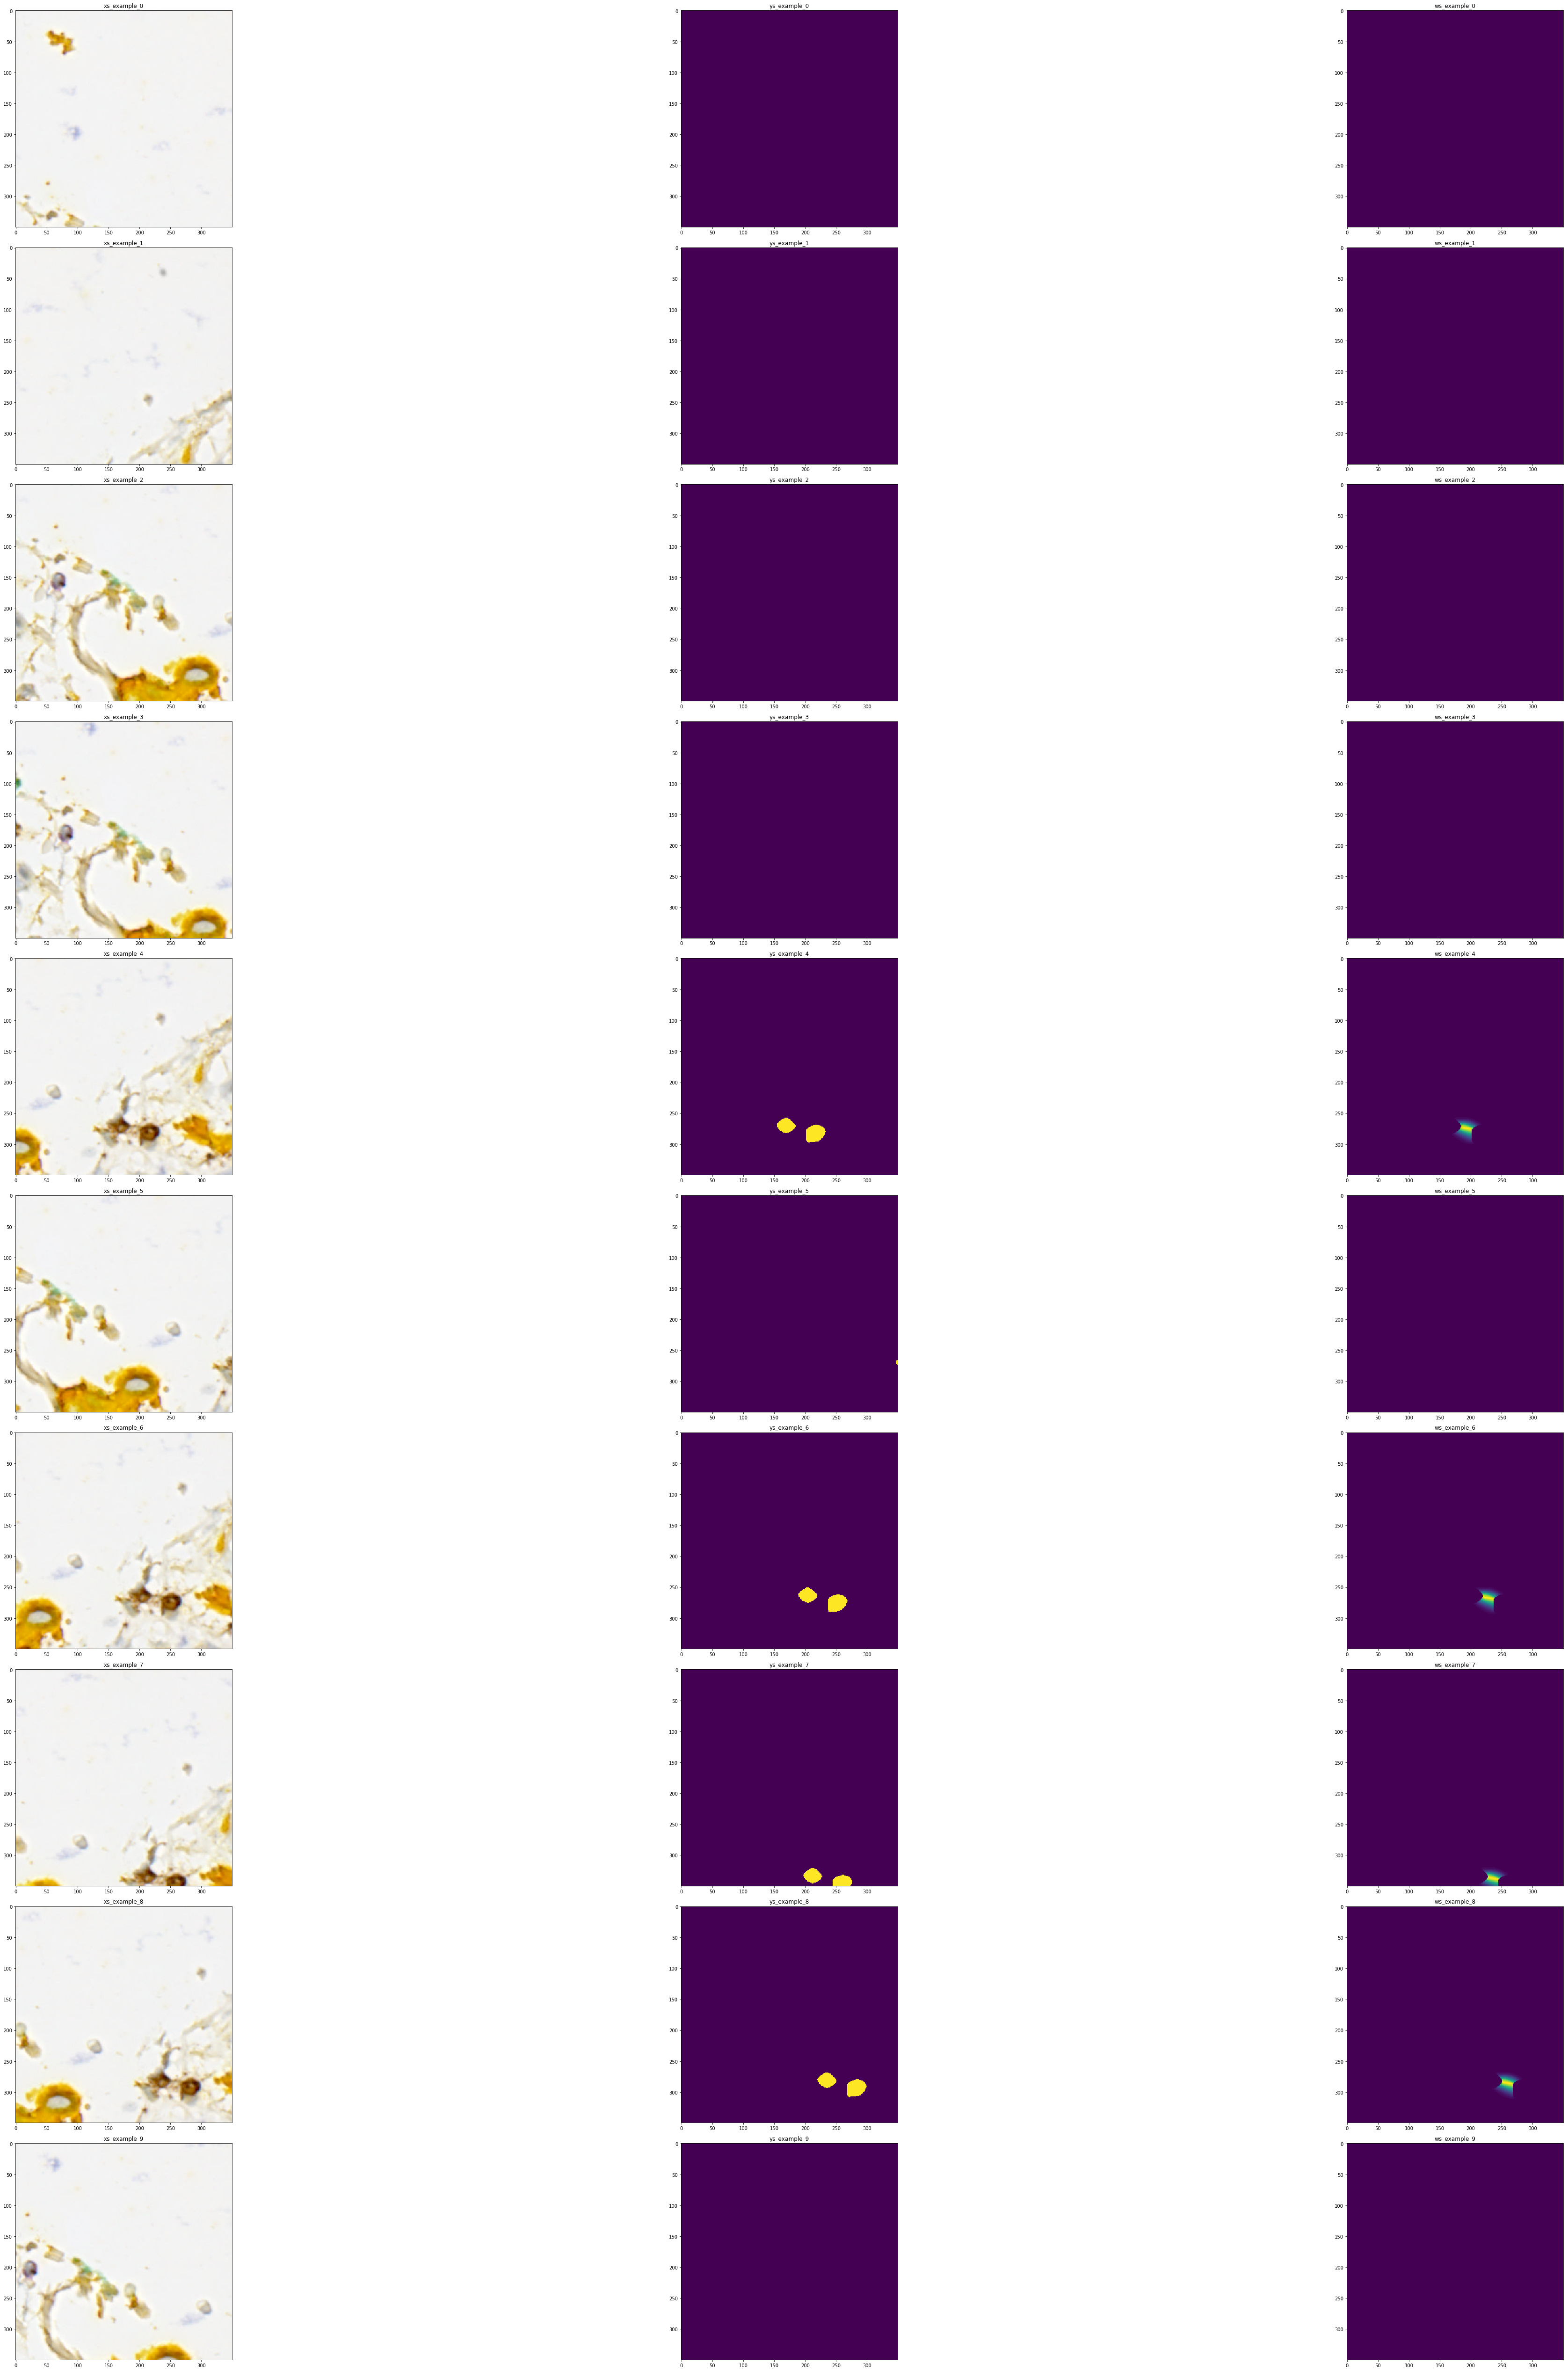

In [3]:
xs,ys,ws= dataset.sample_X_Y_W_patch_batch(input_patch_size,fit=False)
print("xs shape {}\nys shape {}\nxs type {}\nys type {}".format(xs.shape,
                                                                 ys.shape,
                                                                 xs.dtype,
                                                                 ys.dtype))

ys_imgs = from_categorical(ys)
show_batches([xs,ys_imgs,ws],["xs","ys","ws"])

# Training a model

In [4]:
# define your model
from datasets import combine_y_w

model_input_size = input_patch_size + input_channels
unet = Unet(model_input_size, classes=output_channels[0])

def train(model,dataset,epochs=40,n_batch=10):
    losses = []
    metrics = []
    h,w,_ = model.input_shape
    for i in range(epochs):
        print("=========== iteration {}/{} =============".format(i+1,epochs))
        x_train,y_train,w_train = dataset.sample_X_Y_W_patch_batch([h,w],n_batch=n_batch)
        model.fit(x_train,y_train)
        model.evaulate(x_train,y_train)
        loss, metric = model.score
        losses += [loss]
        metrics += [metric]
    return losses, metrics

train(unet,dataset)
        

=========== iteration 1/40 =============
(164, 164, 2)
(10, 164, 164, 2)
Epoch 1/1
10/10 [==============================] - 1s 74ms/step
=========== iteration 2/40 =============
(164, 164, 2)
(10, 164, 164, 2)
Epoch 1/1
10/10 [==============================] - 1s 67ms/step
=========== iteration 3/40 =============
(164, 164, 2)
(10, 164, 164, 2)
Epoch 1/1
10/10 [==============================] - 1s 67ms/step
=========== iteration 4/40 =============
(164, 164, 2)
(10, 164, 164, 2)
Epoch 1/1
10/10 [==============================] - 1s 68ms/step
=========== iteration 5/40 =============
(164, 164, 2)
(10, 164, 164, 2)
Epoch 1/1
10/10 [==============================] - 1s 68ms/step
=========== iteration 6/40 =============
(164, 164, 2)
(10, 164, 164, 2)
Epoch 1/1
10/10 [==============================] - 1s 68ms/step
=========== iteration 7/40 =============
(164, 164, 2)
(10, 164, 164, 2)
Epoch 1/1
10/10 [==============================] - 1s 68ms/step
=========== iteration 8/40 =============


10/10 [==============================] - 1s 70ms/step
=========== iteration 37/40 =============
(164, 164, 2)
(10, 164, 164, 2)
Epoch 1/1
10/10 [==============================] - 1s 70ms/step
=========== iteration 38/40 =============
(164, 164, 2)
(10, 164, 164, 2)
Epoch 1/1
10/10 [==============================] - 1s 70ms/step
=========== iteration 39/40 =============
(164, 164, 2)
(10, 164, 164, 2)
Epoch 1/1
10/10 [==============================] - 1s 70ms/step
=========== iteration 40/40 =============
(164, 164, 2)
(10, 164, 164, 2)
Epoch 1/1
10/10 [==============================] - 1s 70ms/step


([0.67112134099006648,
  0.56413072347640991,
  0.35637281239032748,
  0.40920333564281464,
  0.33961033225059511,
  0.25746779590845109,
  0.20622697919607164,
  0.034511331934481859,
  0.085283757839351895,
  0.072923505492508409,
  0.17546483390033246,
  0.013582147948909551,
  0.049387727238354273,
  0.013319250848144292,
  0.012383868900360539,
  0.049790209648199378,
  0.015958785492694007,
  0.0036695320915896444,
  0.00024252517105196602,
  9.5175719252438284e-05,
  0.00026098139351233841,
  0.034149264357984065,
  0.03669364992529154,
  0.030796525854384527,
  0.022799118730472401,
  0.097099180892109865,
  0.0013101303222356365,
  6.2859197427656001e-06,
  0.01764059783436096,
  4.3682752698259718e-05,
  0.00032494912993570325,
  0.09627571702003479,
  0.022476764849852771,
  0.0067316289801965471,
  0.0059115484978974567,
  1.549215704699236e-06,
  0.030530791520141064,
  0.02743761318270117,
  0.0031215872906614093,
  0.00037433286324812799],
 [0.51539716720581052,
  0.5735

10/10 [==============================] - 1s 72ms/step
1.0
loss: 0.0365606517895, metric: 0.986658245325


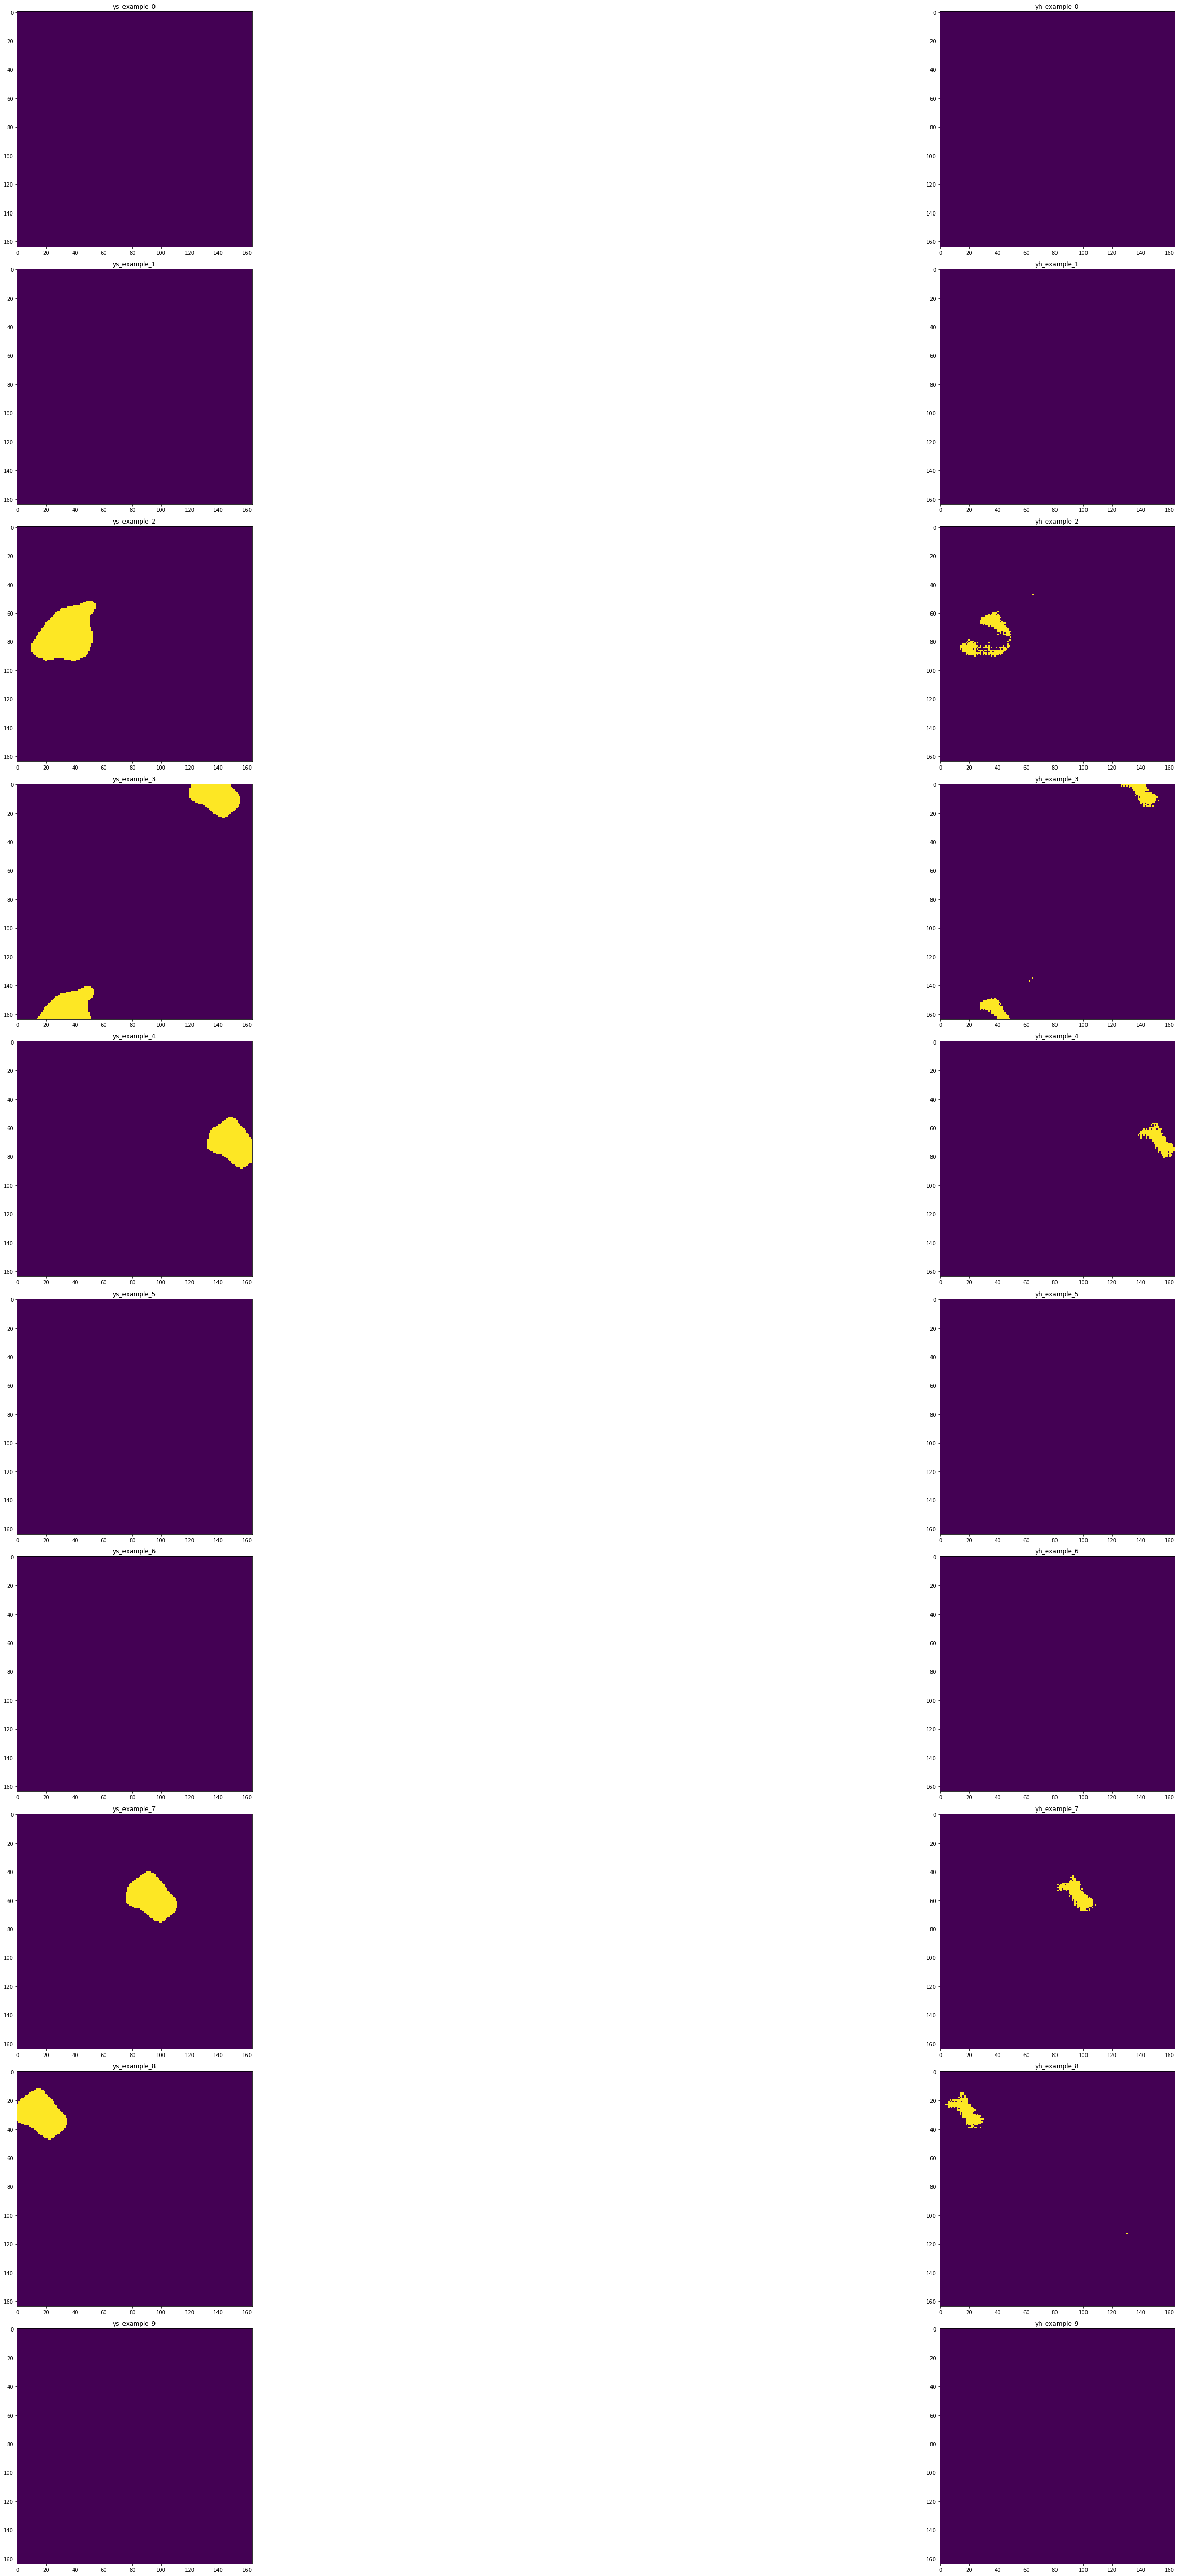

In [6]:
def crop_receptive(batch, crop_size):
    """
        Get a cropped batch to fit the perceptive field,
        the resulting output shape is n,hy,wy,cy.

        args:
            - batch (numpy array) y.shape : n,hx,wx,cy
            - crop_size (list) : hy,wy
    """
    n,hx,wx,_ = batch.shape
    hy,wy = crop_size
    dhq, dhr = (hx-hy)//2, (hx-hy)%2
    dwq, dwr = (wx-wy)//2, (wx-wy)%2
    return batch[:, dhq: hx - (dhq + dhr), dwq: wx - (dwq + dwr) ]

def evaluate(model,dataset,train=True,n_batch=10):
    h,w,_ = model.input_shape
    x_,y_,w_= dataset.sample_X_Y_W_patch_batch([h,w],n_batch=n_batch, train=train)
    y_hat = model.predict(x_)
    model.evaulate(x_,y_)
    loss,metric = model.score
    x_ = crop_receptive(x_,y_hat.shape[1:3])
    y_ = crop_receptive(y_,y_hat.shape[1:3])
    return loss,metric,x_,y_,y_hat

loss,metric,x_,y_,y_hat = evaluate(unet,dataset)
y_imgs = from_categorical(y_)
print(np.max(y_hat))
y_hat_imgs = from_categorical(y_hat)
print("loss: {}, metric: {}".format(loss,metric))
show_batches([y_imgs,y_hat_imgs],["ys","yh"])
    